<a href="https://colab.research.google.com/github/youssefokeil/Computer_Vision_UMICH/blob/main/Finding_Hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction


In this notebook we'll try to find the hyperparameter K in KNNs using 4 ideas.


  1.   Choosing K that works best on training data
  2.   Choosing K that works best on test data
  3.   Splitting data into train, validation and test data
  4.   Using cross-validation.


In each we'll try to mention the merits of each idea and why each might not work well. We'll be using some of the code blocks used in our other notebook called `knn.ipynb` *courtesy of Deep Learning for Computer Vision, UMICH.*



# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['pytorch101.py', 'knn.py', 'knn.ipynb', 'eecs598', 'pytorch101.ipynb']
```

In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
# GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'DL for CV/A1')
print(os.listdir(GOOGLE_DRIVE_PATH))

['eecs598', 'pytorch101.py', 'pytorch101.ipynb', '__pycache__', 'knn.py', 'knn.ipynb']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from knn.py!
```

as well as the last edit time for the file `knn.py`.

In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "Africa/Cairo"
time.tzset()

from knn import hello
hello()

knn_path = os.path.join(GOOGLE_DRIVE_PATH, 'knn.py')
knn_edit_time = time.ctime(os.path.getmtime(knn_path))
print('knn.py last edited on %s' % knn_edit_time)

Hello from knn.py!
knn.py last edited on Thu Jul  4 13:41:20 2024


# Setting Up Dataset

We'll first have to import some packages.

In [ ]:
import eecs598
import torch
import torchvision
import matplotlib.pyplot as plt
import statistics

We'll use the `eecs598` package to download the subsampled CIFAR-10 dataset. It's important to subsample our dataset when implementing machine learning models, to have faster implementations. After being confident enough with our findings, we'll rerun on the whole dataset.

In [ ]:
num_train_sample=1000
num_test_sample=300

train_x, train_y, test_x, test_y=eecs598.data.cifar10(num_train_sample, num_test_sample)

## Visualize dataset

Now let's visualize our data.

*   We've changed our figure and font size
*   We'll make our data visualization script (which we also borrowed from UMICH's notebook `knn.ipynb` ) a generic functon, to be used again.



In [ ]:
import random
from torchvision.utils import make_grid

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

def visualize_data(train_x,train_y):
  classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'] #have to be in order
  samples_per_class = 12
  samples = []
  for y, cls in enumerate(classes):
      plt.text(-4, 34 * y + 18, cls, ha='right')      #plots the text using pyplot plt.text(x,y,text) horizontalalignment='right'
      idxs, = (train_y == y).nonzero(as_tuple=True)   #get indices of class selected in loop
      for i in range(samples_per_class):
          idx = idxs[random.randrange(idxs.shape[0])].item() #takes random index from all indices
          samples.append(train_x[idx])
  img = torchvision.utils.make_grid(samples, nrow=samples_per_class)
  plt.imshow(eecs598.tensor_to_image(img))
  plt.axis('off')
  plt.show()

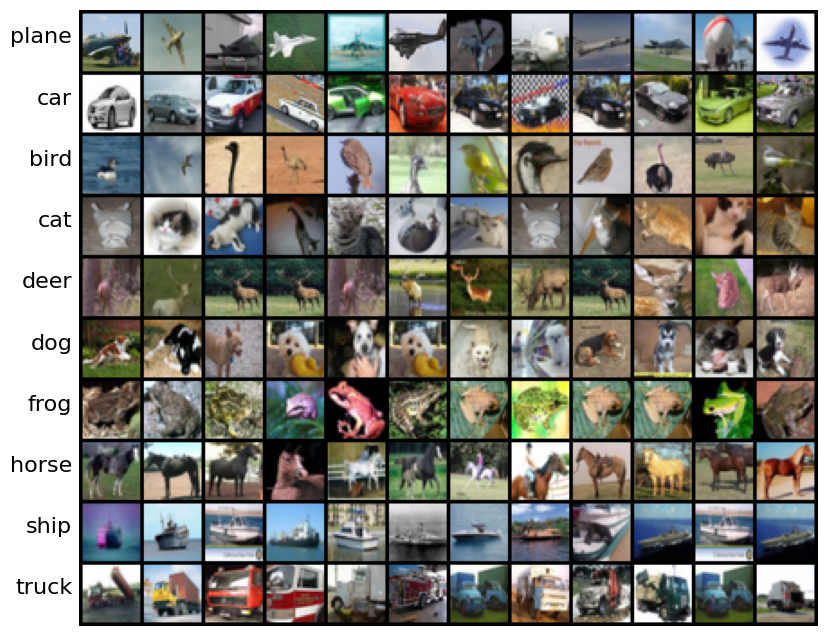

In [ ]:
visualize_data(train_x,train_y)

# Getting K

## Idea 1: What works best on training dataset.

One misstep that new AI practitioners do, is choosing hyperparameters that work best on training data. Let's try that on our dataset, before saying why it doesn't work well.

In [ ]:
from knn import KnnClassifier

classifier = KnnClassifier(train_x, train_y)
k_choices=[1,2,3,4,5,7]


for k in k_choices:
  print("At k=",k)
  accuracy=classifier.check_accuracy(train_x,train_y,k=k)




At k= 1
Got 1000 / 1000 correct; accuracy is 100.00%
At k= 2
Got 527 / 1000 correct; accuracy is 52.70%
At k= 3
Got 473 / 1000 correct; accuracy is 47.30%
At k= 4
Got 443 / 1000 correct; accuracy is 44.30%
At k= 5
Got 415 / 1000 correct; accuracy is 41.50%
At k= 7
Got 364 / 1000 correct; accuracy is 36.40%


By mere looking at the accuracies, we'll find that the best k is k=1 which works with 100% accuracy. This can't be right, the model instead of learning anything useful picked k=1 because, **each image from the tested images (which happens to be the same as our training data) has a nearest neighbor that is the same image itself**, since the tested images are the same as the training images.


> **Key Takeaway:** Don't use training data to pick any of your hyperparameters, it will choose a parameter that works really well on already seen data and will not learn anything useful.




## Idea 2: What work best on test dataset

Since the last idea's problems is the model's not being measured on unseen data. So a good course of action is learning from test dataset, right? It will give us a good estimate on data not seen by the model and will see if it generalizes well on new data.

In [ ]:
from knn import KnnClassifier

classifier = KnnClassifier(train_x, train_y)
k_choices=[1,2,3,4,5,7]


for k in k_choices:
  print("At k=",k)
  accuracy=classifier.check_accuracy(test_x,test_y,k=k)

At k= 1
Got 81 / 300 correct; accuracy is 27.00%
At k= 2
Got 67 / 300 correct; accuracy is 22.33%
At k= 3
Got 71 / 300 correct; accuracy is 23.67%
At k= 4
Got 67 / 300 correct; accuracy is 22.33%
At k= 5
Got 68 / 300 correct; accuracy is 22.67%
At k= 7
Got 64 / 300 correct; accuracy is 21.33%


It seems that the model didn't do so much better than we expected, and still k=1 is the best value. Is that good enough, though? Actually no.


>  We want our model to make predictions on fully unseen data, by using the same dataset to choose our hyperparameters. Then the model is in a way cheated. We want a model to get good results on a data item, because it learnt an underlying thing about it not because it has seen thayt particular item.

As engineers, we evaluate models by looking at predictions on a new type of dataset called "validation set" when we decide to find hyperparameters. This introduces us to the third idea.





## Idea 3: Split data into train,validation,test

Here we're getting near a real solution. Practitioners usually split their data into 3 sets. Based on how fully we want to expose our data in the training and modeling processes.

1. **Training set:** fully exposed, trains our model and find weights of the model
2. **Validation set:** less exposed, used to choose hyperparameters, held back from the training process.
3. **Test set:** used to assess our final result of weight and hyperparameters.


We usually use an 80% training and 20% validation split.

In [ ]:
num_train_new=int(num_train_sample*0.8)

train_xs=train_x[:num_train_new]
train_ys=train_y[:num_train_new]

valid_xs=train_x[num_train_new:]
valid_ys=train_y[num_train_new:]

Let's see how our training and validation data look now.

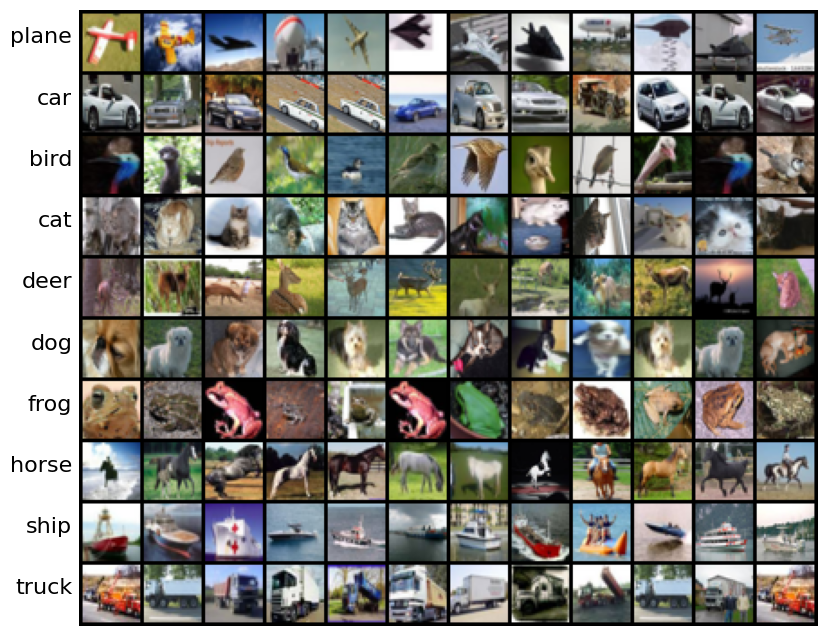

In [ ]:
visualize_data(train_xs,train_ys)

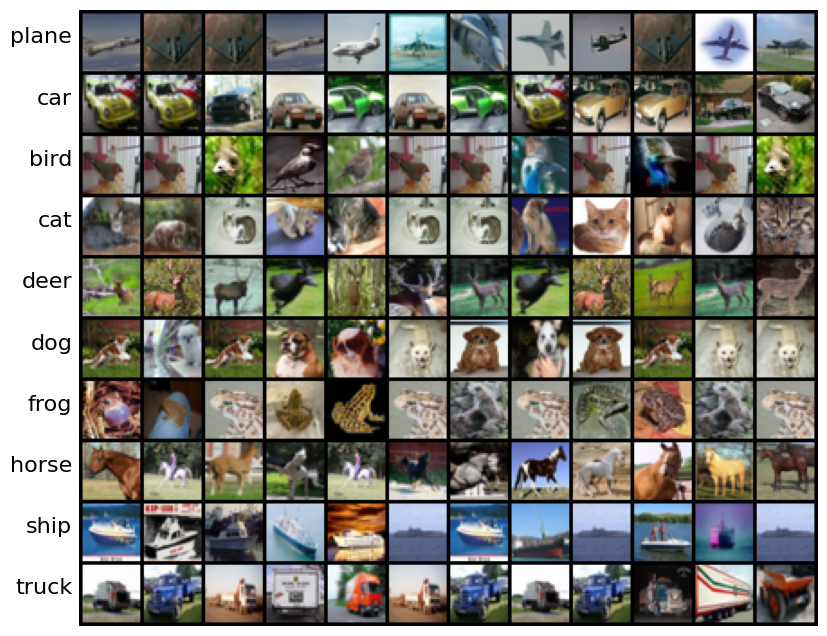

In [ ]:
visualize_data(valid_xs, valid_ys)

It seems that our data was already random split so when we make our naive split between training and validation sets, it worked and each dataset has images of all classes. This is our important point because we don't want a validation set that only has trucks and ships for example.

In [ ]:
from knn import KnnClassifier

classifier_new=KnnClassifier(train_xs,train_ys)
k_choices=[1,2,3,4,5,7,11]

for k in k_choices:
  print("At K=",k)
  classifier_new.check_accuracy(valid_xs,valid_ys,k=k)

At K= 1
Got 35 / 140 correct; accuracy is 25.00%
At K= 2
Got 33 / 140 correct; accuracy is 23.57%
At K= 3
Got 35 / 140 correct; accuracy is 25.00%
At K= 4
Got 37 / 140 correct; accuracy is 26.43%
At K= 5
Got 38 / 140 correct; accuracy is 27.14%
At K= 7
Got 37 / 140 correct; accuracy is 26.43%
At K= 11
Got 40 / 140 correct; accuracy is 28.57%


It seems that k=11 is the best fit for our validation set, despite K=1 being the best fit for our test data with accuracy=27%. Let's see how that hyperparameter performs our test set.

> **Side-note: all of this data is when using training_set=1000, by changing the number of datasets the values can change. Remember, that all of this is for demonstration.**

In [ ]:
print("K=11")
classifier_new.check_accuracy(test_x,test_y,k=11)

K=11
Got 55 / 300 correct; accuracy is 18.33%


18.333333333333332

This further proves our point, that the model cheated before by knowing that k=1 gets 23.67% we picked a hyperparameter that just works well on our test data and normally our accuracy will decrease when we choose a K by not using information from the test set at all.

## Idea 4: Cross-validation

Our last idea, is what's practically used by most modelers and is good enough. But this one will elevate on the idea of using a validation set by using cross-validation. Google defines cross-validation as:

> Cross-validation:  a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data

For our implementation we'll use k-fold cross-validation. Which:

*   splits the data into k folds
*   use k-1 folds to train our data
-   use the kth fold for validation
-   We repeat this k times for each k



<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lOZqYqwmuW1lg6fitwqXxA.png" alt="K-fold cross validation image" width="700" height="400"/>


We'll use the implementation we did in our last notebook.

In [ ]:
from knn import knn_cross_validate

torch.manual_seed(0)
num_train = 1000
num_test = 300
x_train, y_train, x_test, y_test = eecs598.data.cifar10(num_train, num_test)

k_to_accuracies = knn_cross_validate(x_train, y_train, num_folds=5)

for k, accs in sorted(k_to_accuracies.items()):
  print('k = %d got accuracies: %r' % (k, accs))

Got 47 / 200 correct; accuracy is 23.50%
Got 52 / 200 correct; accuracy is 26.00%
Got 52 / 200 correct; accuracy is 26.00%
Got 48 / 200 correct; accuracy is 24.00%
Got 39 / 200 correct; accuracy is 19.50%
Got 36 / 200 correct; accuracy is 18.00%
Got 43 / 200 correct; accuracy is 21.50%
Got 53 / 200 correct; accuracy is 26.50%
Got 44 / 200 correct; accuracy is 22.00%
Got 43 / 200 correct; accuracy is 21.50%
Got 36 / 200 correct; accuracy is 18.00%
Got 37 / 200 correct; accuracy is 18.50%
Got 50 / 200 correct; accuracy is 25.00%
Got 46 / 200 correct; accuracy is 23.00%
Got 39 / 200 correct; accuracy is 19.50%
Got 37 / 200 correct; accuracy is 18.50%
Got 39 / 200 correct; accuracy is 19.50%
Got 56 / 200 correct; accuracy is 28.00%
Got 47 / 200 correct; accuracy is 23.50%
Got 44 / 200 correct; accuracy is 22.00%
Got 34 / 200 correct; accuracy is 17.00%
Got 38 / 200 correct; accuracy is 19.00%
Got 49 / 200 correct; accuracy is 24.50%
Got 50 / 200 correct; accuracy is 25.00%
Got 42 / 200 cor

This is so much data to understand, let's use a visualization technique to try and understand it.

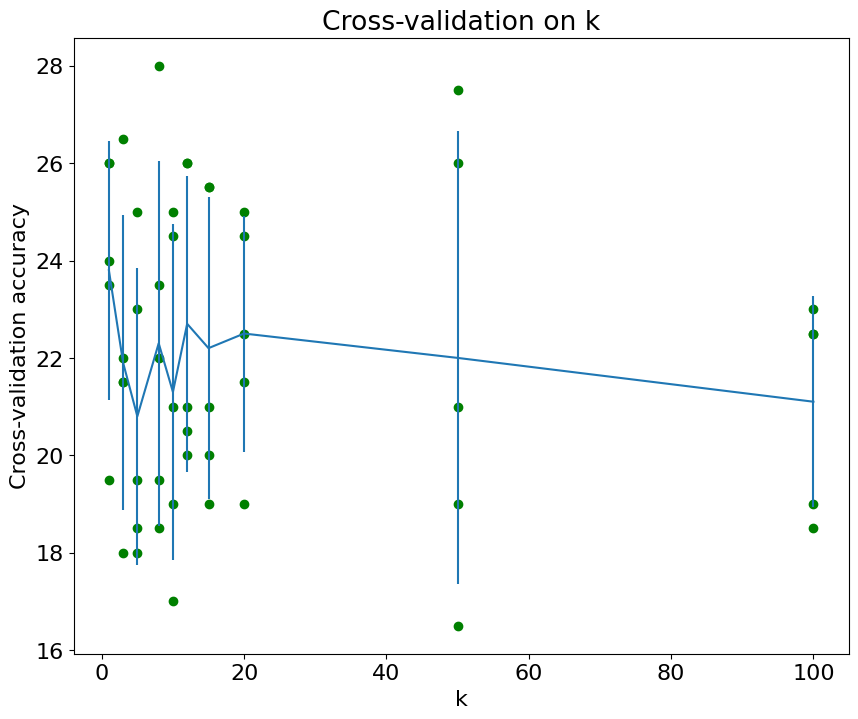

In [ ]:
ks, means, stds = [], [], []
torch.manual_seed(0)
for k, accs in sorted(k_to_accuracies.items()):
  plt.scatter([k] * len(accs), accs, color='g')
  ks.append(k)
  means.append(statistics.mean(accs))
  stds.append(statistics.stdev(accs))
plt.errorbar(ks, means, yerr=stds)
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation on k')
plt.show()

It seems that the best k is 100

In [ ]:
from knn import knn_get_best_k

best_k=knn_get_best_k(k_to_accuracies)
print("best k is", k)
classifier = KnnClassifier(train_xs, train_ys)
classifier.check_accuracy(test_x, test_y, k=best_k)

best k is 100
Got 67 / 300 correct; accuracy is 22.33%


22.333333333333332

# Conclusion

Now we've tried 4 ideas to get hyperparameters.
> The most important key point that is more important and prevalent in any machine learning model is not to cheat yourself by using the test dataset to make decisions about your model. This can hide lots of mishappemns of your model by showing an accuracy that might be better than how the model actually is.

It's always useful to try the cells on the whole dataset. I tried to make the notebook generic enough so that you don't have to change much parameters to rerun all cells with different values for `num_values_sample`